In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm 
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu
from keras.models import load_model

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/cs2")

**FINAL FUNCTION**

In [4]:
def beam_search(image_1,image_2, beam_index):
  # this function will take the input images from the test data and beam index and gives the predicted report and corresponding bleu score for it
      import warnings
      warnings.filterwarnings("ignore")
      #loading the pretrained chexnet model for getting image features
      final_chexnet_model=load_model("chexnet_final.h5")
      #loading embedded matrix
      embedding_matrix=np.load('Embedding_matrix.npy')
      #Loading the pretrained tokenizer
      import pickle
      with open('tokenizer_1.pkl', 'rb') as handle:
        token= pickle.load(handle)
      enc_units=64
      embedding_dim=300
      dec_units=64
      att_units=64
      max_len = 100
      bs = 10
      vocab_size = 1427
      class encoder_decoder(tf.keras.Model):
          def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
                super().__init__()

                              
                self.batch_size=batch_size
                self.encoder =Encoder(enc_units)
                self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
                              
                        
                #Compute the image features using feature extraction model and pass it to the encoder
               # This will give encoder ouput
              # Pass the decoder sequence,encoder_output,initial states to Decoder
              # return the decoder output

                        
          def call(self, data):
              features,report  = data[0], data[1]
                              
              encoder_output= self.encoder(features)
              state_h=self.encoder.initialize_states(self.batch_size)
                              
              output= self.decoder(report, encoder_output,state_h)
                            
              return output
      #encoder model
      #https://www.tensorflow.org/tutorials/text/nmt_with_attention
      class Encoder(tf.keras.Model):
        def __init__(self,units):
          super().__init__()
          self.units=units
          
        
        def build(self,input_shape):
          self.dense1=Dense(self.units,activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 0),name="encoder_dense")
          self.maxpool=tf.keras.layers.Dropout(0.5)

        def call(self,input_):
          enc_out=self.maxpool(input_)
          enc_out=self.dense1(enc_out) 
          
          return enc_out
       #https://www.tensorflow.org/tutorials/text/transformer#decoder
      class Decoder(tf.keras.Model):
          def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
              super().__init__()
        #Intialize necessary variables and create an object from the class onestepdecoder
              self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


                      
          def call(self, input_to_decoder,encoder_output,state_1):

               #Initialize an empty Tensor array, that will store the outputs at each and every time step
               #Create a tensor array as shown in the reference notebook
                      
               #Iterate till the length of the decoder input
              # Call onestepdecoder for each token in decoder_input
             # Store the output in tensorarray
           # Return the tensor array
                      
              all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
              for step in range(input_to_decoder.shape[1]):
                  output,state_1,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1)

                  all_outputs=all_outputs.write(step,output)
              all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
                      
              return all_outputs
#this is the attention class. 
#Here the input to the decoder and the gru hidden state at the pevious time step are given, and the context vector is calculated
#This context vector is calculated uisng the attention weights. This context vector is then passed to the decoder model
#Here conact function is used for calaculating the attention weights
      class Attention(tf.keras.layers.Layer):
          def __init__(self,att_units):

            super().__init__()
    
            self.att_units=att_units

          def build(self,input_shape):
              self.wa=tf.keras.layers.Dense(self.att_units)
              self.wb=tf.keras.layers.Dense(self.att_units)
              self.v=tf.keras.layers.Dense(1)
  
    
          def call(self,decoder_hidden_state,encoder_output):
   
            x=tf.expand_dims(decoder_hidden_state,1)
      
            alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
            alphas=tf.nn.softmax(alpha_dash,1)

            context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]
            # context_vector = alphas*encoder_output
            # print("c",context_vector.shape)


            return (context_vector,alphas)
       #This class will perform the decoder task.
       #The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput at time step t.
       #This output is passed through the final softmax layer with output size =vocab size, and pass this result to the main decoder model
      class One_Step_Decoder(tf.keras.Model):
        def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

            # Initialize decoder embedding layer, LSTM and any other objects needed
          super().__init__()
    
          self.att_units=att_units
          self.vocab_size=vocab_size
          self.embedding_dim=embedding_dim
          self.input_length=input_length
    
          self.dec_units=dec_units
          self.attention=Attention(self.att_units)
          #def build(self,inp_shape):
          self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])

          self.gru=tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform',name="decoder_gru")
          self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense") 
          self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2") 


        def call(self,input_to_decoder, encoder_output, state_h):
    
          embed=self.embedding(input_to_decoder)
          
          context_vector,alpha=self.attention(state_h,encoder_output)
          
          context_vector=self.dense_2(context_vector) 
          
          result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
          
        
          output,decoder_state_1=self.gru(result,initial_state=state_h)
          out=tf.reshape(output,(-1,output.shape[-1]))

          out=tf.keras.layers.Dropout(0.5)(out)
          
          dense_op=self.dense(out)
          
          return dense_op,decoder_state_1,alpha

      def image_feature_extraction(image_1,image_2):
        #gets the features of the given image from pretrained chexnet model
        image_1 = Image.open(image_1)
        image_1= np.asarray(image_1.convert("RGB"))
      
        image_2=Image.open(image_2)
        image_2 = np.asarray(image_2.convert("RGB"))
      
        #normalising the image 
        image_1=image_1/255
        image_2=image_2/255

        #resize the image into (224,224)
        image_1 = cv2.resize(image_1,(224,224))
        image_2 = cv2.resize(image_2,(224,224))
          
        image_1= np.expand_dims(image_1, axis=0)
        image_2= np.expand_dims(image_2, axis=0)
          
      #now we have read two image per patient. this is goven to the chexnet model for feature extraction
          
        image_1_out=final_chexnet_model(image_1)
        image_2_out=final_chexnet_model(image_2)
        #conactenate along the width
        conc=np.concatenate((image_1_out,image_2_out),axis=2)
        #reshape into(no.of images passed, length*breadth, depth)
        image_feature=tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))
      
        return image_feature
      model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)
      #loading the weights
      model.load_weights("model_3/wts")

      hidden_state =  tf.zeros((1, enc_units))
      image_features=image_feature_extraction(image_1,image_2)
      
      def take_second(elem):
        return elem[1]

      encoder_out = model.layers[0](image_features)

      start_token = [token.word_index["<sos>"]]
      dec_word = [[start_token, 0.0]]
      while len(dec_word[0][0]) < max_len:
          temp = []
          for word in dec_word:
              
              predict, hidden_state,alpha = model.layers[1].onestep(tf.expand_dims([word[0][-1]],1), encoder_out, hidden_state)
            
            
              word_predict = np.argsort(predict[0])[-beam_index:]
              for i in word_predict:

                  next_word, probab = word[0][:], word[1]
                  next_word.append(i)
                  probab += predict[0][i] 
                  temp.append([next_word, probab.numpy()])
          dec_word = temp
          # Sorting according to the probabilities scores
          
          
          dec_word = sorted(dec_word, key=take_second)
        
          # Getting the top words
          dec_word = dec_word[-beam_index:] 
          
      
      final = dec_word[-1]
      
      report =final[0]
      score = final[1]
      temp = []
      
      for word in report:
        if word!=0:
          if word != token.word_index['<eos>']:
              temp.append(token.index_word[word])
          else:
              break 

      rep = ' '.join(e for e in temp)        
      
      return rep, score

  
      
      
  

In [20]:

def test():
  import random 
  start=time.time()

  test_dataset = pd.read_csv('test_data_final.csv')
  i=int(input('enter a number from under 399'))
  if i <= 399:

    img1=test_dataset.iloc[i]["Image-1"]
    img2=test_dataset.iloc[i]["Image-2"]
    #show th corresponding x-ray images
    i1=cv2.imread(img1)
    i2=cv2.imread(img2)
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("Image1")
    plt.imshow(i1)
    plt.subplot(132)
    plt.title("Image2")
    plt.imshow(i2)
    plt.show()
    #printing the actual and generated results
    
    result,score=beam_search(img1,img2,3) 
    actual=test_dataset.iloc[i]['Findings']
    actual_ref = actual.split()
    result_ref = result.split()

    
    print("ACTUAL REPORT: ",actual)
    print("GENERATED REPORT: ",result)
    end=time.time() 
    print("BLEU SCORE IS: ",bleu.sentence_bleu(actual_ref,result_ref,weights=(0.25,0.25,0.25,0.25)))

    print("time required for the evaluation is ",end-start)

  else:
    print('The point does not exist')

enter a number from under 3999


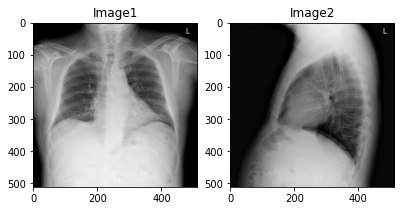

ACTUAL REPORT:  the lungs appear clear .  the heart and pulmonary are normal .  pleural spaces are clear .  mediastinal contours are normal .  patient status post sternotomy and cabg . 
GENERATED REPORT:  <sos> the mediastinal contours . lungs are without focal airspace disease .
BLEU SCORE IS:  0.537284965911771
time required for the evaluation is  11.486265420913696


In [13]:
#random point
Score = test()

enter a number from under 399100


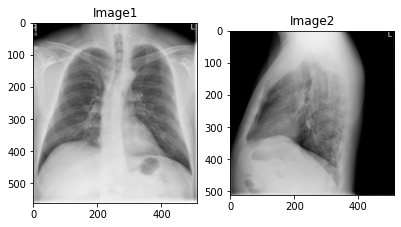

ACTUAL REPORT:  lungs are clear .  no pleural effusions pneumothoraces .  heart and mediastinum normal size and contour . 
GENERATED REPORT:  <sos> the mediastinal contours . no pleural effusion .
BLEU SCORE IS:  0.5773502691896257
time required for the evaluation is  13.709679365158081


In [15]:
score = test()

In [21]:
#for a point not in list
test()

enter a number from under 399577
The point does not exist


enter a number from under 3990


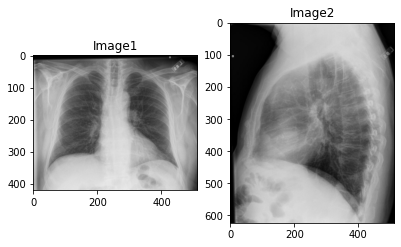

ACTUAL REPORT:  the heart normal size .  the mediastinum stable .  atherosclerotic calcifications the aorta .  there again pleural based density the right lung base related subpleural fat .  the appearance stable from multiple previous studies .  the lungs are clear .  there no pleural effusion . 
GENERATED REPORT:  <sos> the mediastinal contours . no pleural effusion .
BLEU SCORE IS:  0.5773502691896257
time required for the evaluation is  12.080676794052124


In [22]:
#for 0 th point
test()